In [1]:
import warnings
warnings.filterwarnings(action='ignore') #경고 메시지 무시
from IPython.display import display #print가 아닌 display()로 연속 출력
from IPython.display import HTML #출력 결과를 HTML로 생성

In [2]:
import pandas as pd
from collections import OrderedDict
import geopandas
import libpysal
from libpysal import cg, examples
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import matplotlib_scalebar
from matplotlib_scalebar.scalebar import ScaleBar
import numpy
import ortools
from ortools.linear_solver import pywraplp
import seaborn
import shapely
from shapely.geometry import Point
import spaghetti
import sys

%matplotlib inline

# 한글폰트
import os
from matplotlib import font_manager, rc
path = 'C:/Windows/Fonts/malgun.ttf'
font_name = font_manager.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus'] = False 

import numpy as np
import folium

In [3]:
try:
    from IPython.display import Markdown as md
except ImportError:
    pass

In [4]:
class FacilityLocationModel:
    """Solve a facility location optimization model

    Parameters
    ----------
    name : str
        Problem model name; must also be defined as a class method.
    cij : numpy.ndarray
        cost matrix from origins (index of i) to destination (index of j).
        Default is None.
    ai : numpy.ndarray
        Client weight vector. Default is None.
    s : float
        service radius. Default is None.
    p : int
        Density of facilities to site. Default is None.
    write_lp : str
        file name (and path) of the LP file to write out.
    print_sol : bool
        print select results. Default is True.

    Methods
    -------
    build_lscp : build location set covering problem
    build_pmp : build p-median problem
    build_pcp : build p-center problem
    build_mclp : build maximal covering location problem
    add_vars : add variables to a model
    add_constrs : add contraints to a model
    add_obj : add an objective function to a model
    optimize : solve a model
    record_decisions : record optimal decision variables
    non_obj_vals : record non-objective values stats (eg. percent covered)
    print_results : print selected results

    Attributes
    ----------
    model : ortools.linear_solver.pywraplp.Solver
        proxy of <Swig Object of type 'operations_research::MPSolver *'
    n_cli : int
        total client sites
    r_cli : range
        iterable of client sites
    n_fac : int
        total candidate facility sites
    r_fac : range
        iterable of candidate facility sites
    aij : numpy.ndarray
        binary coverage matrix from cij (within s service radius)
    sij : numpy.ndarray
        demand weighted cost matrix as (ai * cij).
    fac_vars : dict
        facility decision variables
    cli_vars : dict
        client decision variables
    W : ortools.linear_solver.pywraplp.Variable
        minimized maximum variable in the p-center problem formulation
    lp_formulation : str
        linear programming formulation of the model
    solve_minutes : float
        solve time in minutes
    obj_val : int or float
        model objective value
    fac2cli : dict
        facility to client relationship lookup
    cli2fac : dict
        client to facility relationship lookup
    fac2iloc : dict
        facility to dataframe index location lookup
    n_cli_uncov : int
        count of client location outside the service radius
    cli2ncov : dict
        client to covered by count lookup
    ncov2ncli : dict
        covered by count to client count lookup
    mean_dist :
        mean distance per person to the assigned facility
    perc_served :
        percentage of weighted clients covered in `s`
    """

    def __init__(
        self, name, ai=None, cij=None, s=None, p=None, write_lp=None, print_sol=True
    ):
        # Set model information
        self.name = name
        # create a solver instance
        solver_instance = pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING
        # instantiate a model
        self.model = pywraplp.Solver(self.name, solver_instance)

        # Set parameters and indices
        # facility parameter
        if p:
            self.p = p
        # client count and range
        self.cij = cij
        self.n_cli = cij.shape[0]
        self.r_cli = range(self.n_cli)
        # facility count and range
        self.n_fac = self.cij.shape[1]
        self.r_fac = range(self.n_fac)
        # demand parameter
        if ai is not None:
            self.ai = ai
            self.ai_sum = ai.sum()
            # weighted demand
            try:
                self.sij = self.ai * self.cij
            except ValueError:
                self.ai = self.ai.values.reshape(self.n_cli, 1)
                self.sij = self.ai * self.cij
        # if the model has a service radius parameter
        if s:
            self.s = s
            # binary coverage matrix from cij
            self.aij = numpy.zeros(self.cij.shape)
            self.aij[self.cij <= self.s] = 1.0

        # Set decision variables, constraints, and objective function
        try:
            getattr(self, "build_" + self.name)()
        except:
            raise AttributeError(self.name, "not a defined location model.")

        # solve
        self.optimize(write_lp=write_lp)
        # records seleted decision variables
        self.record_decisions()
        # record non-objective values stats (eg. percent covered)
        self.non_obj_vals()
        # print results
        if print_sol:
            self.print_results()

    def build_lscp(self):
        """ Integer programming formulation of the Location Set Covering Problem.
        Originally Published:
            Toregas, C. and ReVelle, Charles. 1972.
            Optimal Location Under Time or Distance Constraints.
            Papers of the Regional Science Association. 28(1):133 - 144.
        """
        # Decision Variables
        self.add_vars()
        # Constraints
        self.add_constrs(constr=1)  # set coverage constraints
        # Objective Function
        self.add_obj()

    def build_pmp(self):
        """Integer programming formulation of the p-median Problem.
        Originally Published:
            S. L. Hakimi. 1964. Optimum Locations of Switching Centers and
            the Absolute Centers and Medians of a Graph. Operations Research.
            12 (3):450-459.
        Adapted from:
                -1-
            ReVelle, C.S. and Swain, R.W. 1970. Central facilities location.
            Geographical Analysis. 2(1), 30-42.
                -2-
            Toregas, C., Swain, R., ReVelle, C., Bergman, L. 1971. The Location
            of Emergency Service Facilities. Operations Research. 19 (6),
            1363-1373.
                - 3 -
            Daskin, M. (1995). Network and discrete location: Models, algorithms,
            and applications. New York: John Wiley and Sons, Inc.
        """
        # Decision Variables
        self.add_vars()
        # Constraints
        self.add_constrs(constr=2)  # assignment constraints
        self.add_constrs(constr=3)  # facility constraint
        self.add_constrs(constr=4)  # opening constraints
        # Objective Function
        self.add_obj()

    def build_pcp(self):
        """Integer programming formulation of the p-center Problem.
        Originally Published:
            S. L. Hakimi. 1964. Optimum Locations of Switching Centers and
            the Absolute Centers and Medians of a Graph. Operations Research.
            12 (3):450-459.
        Adapted from:
            Daskin, M. (1995). Network and discrete location: Models, algorithms,
            and applications. New York: John Wiley and Sons, Inc.
        """
        # Decision Variables
        self.add_vars()
        # Constraints
        self.add_constrs(constr=2)  # assignment constraints
        self.add_constrs(constr=3)  # facility constraint
        self.add_constrs(constr=4)  # opening constraints
        self.add_constrs(constr=5)  # minimized maximum constraints
        # Objective Function
        self.add_obj()

    def build_mclp(self):
        """Integer programming formulation of the Maximal Covering Location Problem.
        Originally Published:
            Church, R. L and C. ReVelle. 1974. The Maximal Covering Location
            Problem. Papers of the Regional Science Association. 32:101-18.
        """
        # Decision Variables
        self.add_vars()
        # Constraints
        self.add_constrs(constr=3)  # facility constraint
        self.add_constrs(constr=6)  # maximal coverage constraints
        # Objective Function
        self.add_obj()

    def add_vars(self):
        """Add variables to a model."""
        # facility decision variables
        self.fac_vars = {j: self.model.IntVar(0, 1, "y[%i]" % (j)) for j in self.r_fac}
        # client decision variables
        if self.name == "mclp":
            self.cli_vars = {
                (i): self.model.IntVar(0, 1, "x[%i]" % (i)) for i in self.r_cli
            }
        if self.name == "pmp" or self.name == "pcp":
            self.cli_vars = {
                (i, j): self.model.IntVar(0, 1, "x[%i,%i]" % (i, j))
                for i in self.r_cli
                for j in self.r_fac
            }
        # minimized maximum variable
        if self.name == "pcp":
            self.W = self.model.NumVar(0, self.model.infinity(), "W")

    def add_constrs(self, constr=None):
        """ Add constraints to a model.
        (1) set coverage constraints
                y1 + x2 >= 1
                x1 + x3 >= 1
                x2 >= 1
        (2) assignment constraints
                x1_1 + x1_2 + x1_3 = 1
        (3) facility constraints
                y1 + y2 + y3 = p
        (4) opening constraints
                - x1_1 + y1 >= 0
                - x2_1 + y1 >= 0
                - x3_1 + y1 >= 0
        (5) minimax constraints
                cost1_1*x1_1 + cost1_2*x1_2 + cost1_3*x1_3 - W <= 0
        (6) maximal coverage constraints
                - x1 + y1 + y3 >= 0
                - x2 + y4 >= 0
        Parameters
        ----------
        constr : int {1, 2, 3, 4, 5, 6}
            Contraint type to add to model. See above for explanation.
            Default is None.
        """
        # 1 - set covering constraints
        if constr == 1:
            for i in self.r_cli:
                self.model.Add(
                    self.model.Sum(
                        [self.aij[i, j] * self.fac_vars[j] for j in self.r_fac]
                    )
                    >= 1
                )
        # 2 - assignment constraints
        elif constr == 2:
            for i in self.r_cli:
                self.model.Add(
                    self.model.Sum([self.cli_vars[i, j] for j in self.r_fac]) == 1
                )
        # 3 - facility constraint
        elif constr == 3:
            self.model.Add(
                self.model.Sum([self.fac_vars[j] for j in self.r_fac]) == self.p
            )
        # 4 - opening constraints
        elif constr == 4:
            for i in self.r_cli:
                for j in self.r_fac:
                    self.model.Add(self.fac_vars[j] - self.cli_vars[i, j] >= 0)
        # 5 - minimax constraints
        elif constr == 5:
            for i in self.r_cli:
                self.model.Add(
                    self.model.Sum(
                        [self.cij[i, j] * self.cli_vars[i, j] for j in self.r_fac]
                    )
                    <= self.W
                )
        # 6 - max coverage constraints
        elif constr == 6:
            for i in self.r_cli:
                self.model.Add(
                    self.model.Sum(
                        [self.aij[i, j] * self.fac_vars[j] for j in self.r_fac]
                    )
                    >= self.cli_vars[i]
                )

    def add_obj(self):
        """Add an objective function to a model."""
        if self.name == "lscp":
            self.model.Minimize(self.model.Sum([self.fac_vars[j] for j in self.r_fac]))

        elif self.name == "pmp":
            obj = [
                self.sij[i, j] * self.cli_vars[i, j]
                for i in self.r_cli
                for j in self.r_fac
            ]
            self.model.Minimize(self.model.Sum(obj))

        elif self.name == "pcp":
            self.model.Minimize(self.W)

        elif self.name == "mclp":
            obj = [self.ai.flatten()[i] * self.cli_vars[i] for i in self.r_cli]
            self.model.Maximize(self.model.Sum(obj))

    def optimize(self, write_lp=False):
        """ Solve the model.
        Parameters
        ----------
        write_lp : bool
            write out the linear programming formulation
        """

        def _redirect_to_file(self, text):
            """ Write out the model in linear programming format.
            Parameters
            ----------
            text : str
                full lp formulation in str format
            """
            original = sys.stdout
            sys.stdout = open(self.name + ".lp", "w")
            print(text)
            sys.stdout = original

        self.model.Solve()
        # linear programming formulation
        if write_lp:
            self.lp_formulation = self.model.ExportModelAsLpFormat(True)
            self._redirect_to_file(self.lp_formulation)
        # WallTime() in milliseconds
        self.solve_minutes = self.model.WallTime() * 1.66667e-5
        self.obj_val = self.model.Objective().Value()

    def record_decisions(self):
        """Record decision variable relationship folowing optimization."""
        # facility-to-dataframe index location lookup
        self.fac2iloc = {v.name(): k for k, v in self.fac_vars.items()}
        # client-to-dataframe index location lookup
        self.cli2iloc = {}
        # facility-to-client lookup
        self.fac2cli = {}

        # record client/service relationships
        for j in self.r_fac:
            if self.fac_vars[j].solution_value() > 0:
                jvar = self.fac_vars[j].name()
                self.fac2cli[jvar] = []
                for i in self.r_cli:
                    ivar = None
                    if self.name == "lscp":
                        if self.aij[i, j] > 0:
                            ivar = "x[%i]" % i
                            self.fac2cli[jvar].append(ivar)
                    elif self.name == "mclp":
                        if self.cli_vars[i].solution_value() > 0:
                            if self.aij[i, j] > 0:
                                ivar = self.cli_vars[i].name()
                                self.fac2cli[jvar].append(ivar)
                    else:
                        if self.cli_vars[i, j].solution_value() > 0:
                            ivar = self.cli_vars[i, j].name()
                            ivar = ivar.split(",")[0] + "]"
                            self.fac2cli[jvar].append(ivar)
                    if ivar:
                        self.cli2iloc[ivar] = i

        # client-to-facility lookup
        self.cli2fac = {}
        for cv in list(self.cli2iloc.keys()):
            self.cli2fac[cv] = []
            for k, v in self.fac2cli.items():
                if cv in v:
                    self.cli2fac[cv].append(k)

        # count of uncovered clients
        self.n_cli_uncov = self.n_cli - len(self.cli2iloc.keys())

        # clients of clients covered by n facilities
        if self.name == "lscp" or self.name == "mclp":
            self.cli2ncov = {}
            for c, fs in self.cli2fac.items():
                self.cli2ncov[c] = len(fs)
            most_coverage = max(self.cli2ncov.values())
            self.ncov2ncli = {}
            for cov_count in range(most_coverage + 1):
                if cov_count == 0:
                    self.ncov2ncli[cov_count] = self.n_cli_uncov
                    continue
                if not cov_count in list(self.cli2ncov.keys()):
                    self.ncov2ncli[cov_count] = 0
                for c, ncov in self.cli2ncov.items():
                    if ncov >= cov_count:
                        self.ncov2ncli[cov_count] += 1

    def non_obj_vals(self):
        """Record non-objective values."""
        if self.name == "pmp":
            self.mean_dist = self.obj_val / float(self.ai_sum)

        if self.name == "mclp":
            self.perc_served = (self.obj_val / float(self.ai_sum)) * 100.0

    def print_results(self):
        """Print select results."""
        print("Solve Time:", self.solve_minutes, "minutes")

        # solve time and objective value
        if self.name == "lscp":
            u1 = "facilities needed for total coverage within a "
            u2 = "%f meter service radius" % self.s
        if self.name == "pmp":
            u1 = "total weighted distance with "
            u2 = "%i selected facilities" % self.p
        if self.name == "pcp":
            u1 = "worst case distance with "
            u2 = "%i selected facilities" % self.p
        if self.name == "mclp":
            u1 = "residents within %f meters of " % self.s
            u2 = "%i selected facilities" % self.p
        units = u1 + u2

        print("Obj. Value:", self.obj_val, units)

        if self.name == "pmp":
            print("Mean weighted distance per", "person: %f" % self.mean_dist)
        if self.name == "mclp":
            print(
                "Percent of %i" % self.ai_sum, "clients covered: %f" % self.perc_served
            )

        # coverage values
        if self.name == "lscp" or self.name == "mclp":
            for ncov, ncli in self.ncov2ncli.items():
                if ncov == 0:
                    print("--- %i clients are not covered" % ncli)
                else:
                    if ncov == 1:
                        sp = "y"
                    else:
                        sp = "ies"
                    print(
                        "--- %i clients are covered" % ncli,
                        "by %i" % ncov,
                        "facilit" + sp,
                    )

In [5]:
def add_results(model, cli_df, fac_df, print_solution=False):
    """Add decision variable relationships to a dataframe.
    Parameters
    ----------
    model : ortools.linear_solver.pywraplp.Solver
        proxy of <Swig Object of type 'operations_research::MPSolver *'
    cli_df : geopandas.GeoDataFrame
        GeoDataFrame of client locations
    fac_df : geopandas.GeoDataFrame
        GeoDataFrame of facility locations
    print_solution : bool
        print out solution decision variables. Default is False.
    Returns
    -------
    cli_df : geopandas.GeoDataFrame
        updated client locations
    fac_df : geopandas.GeoDataFrame
        updated facility locations
    """
    col_name = model.name + "_sol"
    fillers = [[cli_df, "cli2fac"], [fac_df, "fac2cli"]]
    for df, attr in fillers:
        df[col_name] = df["dv"].map(getattr(model, attr))
        df[col_name].fillna("closed", inplace=True)
    if print_solution:
        selected = fac_df[fac_df[col_name] != "closed"]
        for idx in selected.index:
            print("")
            print(selected.loc[idx, "dv"], "serving:", selected.loc[idx, col_name])
    return cli_df, fac_df

In [60]:
def plotter(
    fig=None,
    base=None,
    plot_aux=None,
    buffered=None,
    model=None,
    pt1_size=None,
    pt2_size=None,
    plot_res=None,
    save_fig=False,
    title=None,
    figsize=(10, 10)
):
    """ Top-level scenario plotter for location analytics.
    Parameters
    ----------
    fig : matplotlib.figure.Figure
        complete figure to plot. Default is None.
    base : matplotlib.axes._subplots.AxesSubplot
        individual axis to plot. Default is None.
    plot_aux : dict
        model data parameters dataframes to plot keyed by
        descriptive names. Default is None.
    plot_res : dict
        model data results dataframes to plot keyed by
        descriptive names. Default is None.
    buffered : see
        buffer distance from roads segments in `plot_base`.
        Default is None.
    pt1_size : float or float
        size of points to plot. `pt1_size` should always be the
        larger between `pt2_size` and `pt1_size`. Default is None.
    pt2_size : float or float
        size of points to plot. Default is None.
    model : ortools.linear_solver.pywraplp.Solver
        proxy of <Swig Object of type 'operations_research::MPSolver *'
    title : str
        plot title. Default is None.
    figsize : tuple
        Figure size for plot. Default is (12,12).
    save_fig : bool
        Default is False.
    Returns
    -------
    add_to_legend : list
        items to add to legend
    """
    for_multiplot = True
    if not fig and not base:
        for_multiplot = False
        fig, base = plt.subplots(1, 1, figsize=figsize)

    # add title
    if not for_multiplot:
        if model:
            title += " - " + model.name
        base.set_title(title, size=20)
    else:
        base.set_title(model.name, size=20)

    # plot non-results data
    if plot_aux:
        for k, df in plot_aux.items():
            if k == "streets":
                df.plot(ax=base, lw=2, edgecolor="k", zorder=1,color='dimgray')
            if k == "buffer":
                df.plot(ax=base, facecolor="y", lw=0.25, alpha=0.25, zorder=1)
            if k == "cli_tru":
                if plot_res:
                    df = df[df[model.name + "_sol"] == "closed"]
                    psize = pt2_size / 6.0
                    pcolor = "k"
                else:
                    n_cli = df.shape[0]
                    psize = pt1_size
                    pcolor = "r"
                df.plot(ax=base, markersize=psize, edgecolor="k", facecolor=pcolor)
            if k == "fac_tru":
                if plot_res:
                    df = df[df[model.name + "_sol"] == "closed"]
                    psize = pt2_size
                    pcolor = "k"
                    pmarker = "*"
                else:
                    n_cli = df.shape[0]
                    psize = pt1_size
                    pcolor = "b"
                    pmarker = "o"
                df.plot(
                    ax=base,
                    markersize=psize,
                    edgecolor="k",
                    facecolor=pcolor,
                    marker=pmarker,
                )
                n_fac = df.shape[0]
            if k == "cli_snp":
                df.plot(
                    ax=base,
                    markersize=pt2_size,
                    edgecolor="k",
                    facecolor="r",
                    alpha=0.75,
                )
            if k == "fac_snp":
                df.plot(
                    ax=base,
                    markersize=pt2_size,
                    edgecolor="k",
                    facecolor="b",
                    alpha=0.75,
                )
        add_to_legend = list(plot_aux.keys())
    else:
        add_to_legend = None

    # plot results data
    if plot_res:
        dv_colors = dv_colorset(plot_res["fac_var"].dv)
        # facilities
        df = plot_res["fac_var"][plot_res["fac_var"][model.name + "_sol"] != "closed"]
        alpha = 1.0 / float(len(df.dv))
        if alpha > 0.5:
            alpha = 0.5
        # decision variable info for legend
        dvs_to_leg = {}
        # plot facilities
        for dv in df.dv:
            fac = df[df.dv == dv]
            fac.plot(
                ax=base,
                marker="*",
                markersize=pt1_size * 3.0,
                alpha=0.8,
                zorder=3,
                edgecolor="k",
                facecolor=dv_colors[dv],
            )
            # update decision variable info with set color
            dvs_to_leg[dv] = {"facecolor": dv_colors[dv]}
        # plot clients & service areas
        for f, c in model.fac2cli.items():
            fc = plot_res["cli_var"][plot_res["cli_var"].dv.isin(c)]
            fc.plot(
                ax=base,
                markersize=50,
                edgecolor="k",
                facecolor=dv_colors[f],
                alpha=alpha,
                zorder=2,
            )
            # update decision variable info with set client counts
            dvs_to_leg[f].update({"clients": fc.shape[0]})
            # create service area polygon
            service_area = concave_hull(df, fc, f)
            service_area.plot(
                ax=base, edgecolor="k", alpha=0.2, facecolor=dv_colors[f], zorder=1
            )
    else:
        dvs_to_leg = None

    if not model:

        class _ShellModel:
            """Object to mimic `model` when not present."""

            def __init__(self, plot_aux):
                try:
                    self.n_cli = plot_aux["cli_tru"].shape[0]
                    try:
                        self.n_fac = plot_aux["fac_tru"].shape[0]
                    except KeyError:
                        pass
                except KeyError:
                    pass

        try:
            model = _ShellModel(plot_aux)
        except (TypeError, KeyError):
            model = None

    if not for_multiplot:
        # create legend patches
        patches = create_patches(
            model=model,
            for_multiplot=for_multiplot,
            pt1_size=pt1_size,
            pt2_size=pt2_size,
            buffered=buffered,
            legend_aux=add_to_legend,
            dvs_to_leg=dvs_to_leg,
        )
        add_legend(patches, for_multiplot=for_multiplot)
    add_north_arrow(base)
    add_scale(base)

    if save_fig:
        plt.savefig(model.name + ".png")

    # if for a multiplot explicityly return items to add to legend
    if for_multiplot:
        return add_to_legend

In [7]:
def multi_plotter(
    models,
    plot_aux=None,
    plot_res=None,
    select=None,
    title=None,
    figsize=(14, 14),
    shape=(2, 2),
):
    """plot multiple base axes as one figure
    Parameters
    ----------
    models : list
        solved model objects
    select : dict
        facility-to-selection count lookup.
    shape : tuple
        dimension for subplot array. Default is (2,2).s
    plot_aux : see plotter()
    plot_res : see plotter()
    title : see plotter()
    figsize : see plotter()
    """
    pt1_size, pt2_size = 300, 60
    # convert list of models to array
    mdls = numpy.array(models).reshape(shape)
    fig, axarr = plt.subplots(
        mdls.shape[0], mdls.shape[1], figsize=figsize, sharex="col", sharey="row"
    )
    # add super title to subplot array
    plt.suptitle(title, fontsize=30)
    fig.subplots_adjust(hspace=0.1, wspace=0.005, top=0.925)
    # create each subplot
    for i in range(mdls.shape[0]):
        for j in range(mdls.shape[1]):
            add_to_legend = plotter(
                base=axarr[i, j],
                plot_aux=plot_aux,
                plot_res=plot_res,
                model=mdls[i, j],
                pt1_size=pt1_size,
                pt2_size=pt2_size,
            )
            axarr[i, j].set_aspect("equal")
    add_to_legend = set(add_to_legend)
    # decision variable color set
    dv_colors = dv_colorset(plot_res["fac_var"].dv)
    dvs_to_leg = {f: dv_colors[f] for m in models for f in m.fac2cli.keys()}
    # set ordered dict of {iloc:fac_var, color, x-selected}
    # *** models[0] can be any of the solved models
    dvs_to_leg = {
        models[0].fac2iloc[k]: (k, v, select[k]) for k, v in dvs_to_leg.items()
    }
    dvs_to_leg = OrderedDict(sorted(dvs_to_leg.items()))
    # create legend patches
    patches = create_patches(
        model=None,
        pt1_size=pt1_size,
        pt2_size=pt2_size,
        legend_aux=add_to_legend,
        dvs_to_leg=dvs_to_leg,
        for_multiplot=True,
    )
    add_legend(patches, for_multiplot=True)

In [8]:
def add_north_arrow(base):
    """add a north arrow to an axes
    Parameters
    ----------
    base : see plotter()
    """
    arw = "rarrow, pad=0.25"
    bbox_props = dict(boxstyle=arw, fc="w", ec="k", lw=2, alpha=0.75)
    base.text(
        221200,
        267200,
        "      z    ",
        bbox=bbox_props,
        fontsize="large",
        fontweight="heavy",
        ha="center",
        va="center",
        rotation=90,
    )

In [9]:
def add_scale(base):
    """add a scale bar to an axes
    Parameters
    ----------
    base : see plotter()
    """
    scalebar = ScaleBar(1, units="m", location="lower left")
    base.add_artist(scalebar)
    base.set(xticklabels=[], xticks=[], yticklabels=[], yticks=[]);

In [10]:
def create_patches(
    model=None,
    pt1_size=None,
    pt2_size=None,
    buffered=None,
    legend_aux=None,
    dvs_to_leg=None,
    for_multiplot=False,
):
    """create all patches to add to the legend.
    Parameters
    ----------
    for_multiplot : bool
        for a single plot (True), or multiplot (False).
        Default is False.
    model : see plotter()
    pt1_size : see plotter()
    pt2_size : see plotter()
    buffered : see plotter()
    legend_aux : see plotter()
    dvs_to_leg : see plotter()
    Returns
    -------
    patches : list
        legend handles matching plotted items
    """
    if pt1_size:
        ms1 = float(pt1_size) / 6.0
    if pt2_size:
        ms2 = float(pt2_size) / 8.0
    # streets -- always plot
    strs = mlines.Line2D([], [], color="k", linewidth=2, alpha=1, label="Streets")
    # all patches to add to legend
    patches = [strs]
    # non-results data
    if legend_aux:
        if "buffer" in legend_aux:
            label = "Street buffer (%sm)" % buffered
            strbuff = mpatches.Patch(
                edgecolor="None", facecolor="y", linewidth=2, alpha=0.5, label=label
            )
            patches.append(strbuff)
        if "cli_tru" in legend_aux:
            try:
                if dvs_to_leg:
                    pcolor = "k"
                    msize = ms2 / 3.0
                    plabel = "Uncovered Households " + "($n$=%i)" % model.n_cli_uncov
                else:
                    pcolor = "r"
                    msize = ms1
                    plabel = "Households ($n$=%i)" % model.n_cli
                cli_tru = mlines.Line2D(
                    [],
                    [],
                    color=pcolor,
                    marker="o",
                    ms=msize,
                    linewidth=0,
                    alpha=1,
                    markeredgecolor="k",
                    label=plabel,
                )
                patches.append(cli_tru)
            except AttributeError:
                pass
        if "fac_tru" in legend_aux:
            if dvs_to_leg:
                pcolor = "k"
                msize = ms2
                pmarker = "*"
                no_fac = model.n_fac - len(list(model.fac2cli.keys()))
                plabel = "Unselected Facilities ($n$=%i)" % no_fac
            else:
                pcolor = "b"
                msize = ms1
                pmarker = "o"
                plabel = "Little Free Library candidates" + "($n$=%i)" % model.n_fac
            fac_tru = mlines.Line2D(
                [],
                [],
                color=pcolor,
                marker=pmarker,
                ms=msize,
                markeredgecolor="k",
                linewidth=0,
                alpha=1,
                label=plabel,
            )
            patches.append(fac_tru)
        if "cli_snp" in legend_aux:
            label = "Households snapped to network"
            cli_snp = mlines.Line2D(
                [],
                [],
                color="r",
                marker="o",
                ms=ms2,
                linewidth=0,
                alpha=1,
                markeredgecolor="k",
                label=label,
            )
            patches.append(cli_snp)
        if "fac_snp" in legend_aux:
            label = "LFL candidates snapped to network"
            fac_snp = mlines.Line2D(
                [],
                [],
                color="b",
                marker="o",
                ms=ms2,
                markeredgecolor="k",
                linewidth=0,
                alpha=1,
                label=label,
            )
            patches.append(fac_snp)
    # results data for single plot
    if dvs_to_leg and not for_multiplot:
        # add facility, client, and service area patches to legend
        for k, v in dvs_to_leg.items():
            fdv_label = "Little Free Library %s" % k
            fdv = mlines.Line2D(
                [],
                [],
                color=v["facecolor"],
                marker="*",
                ms=ms1 / 2.0,
                markeredgecolor="k",
                linewidth=0,
                alpha=0.8,
                label=fdv_label,
            )
            cdv_label = "Households served by %s " % k + "($n$=%i)" % v["clients"]
            cdv = mlines.Line2D(
                [],
                [],
                color=v["facecolor"],
                marker="o",
                ms=ms1 / 6.0,
                markeredgecolor="k",
                linewidth=0,
                alpha=0.5,
                label=cdv_label,
            )
            serv_label = "%s service area" % k
            serv = mpatches.Patch(
                edgecolor="k",
                facecolor=v["facecolor"],
                linewidth=2,
                alpha=0.25,
                label=serv_label,
            )
            patches.extend([fdv, cdv, serv])
    # results data for multiplot
    if dvs_to_leg and for_multiplot:
        for idx, (k, v, n) in dvs_to_leg.items():
            fdv = mlines.Line2D(
                [],
                [],
                color=v,
                marker="*",
                ms=ms1 / 2,
                markeredgecolor="k",
                linewidth=0,
                alpha=0.8,
                label="%s ($n$=%i)" % (k, n),
            )
            patches.append(fdv)
    return patches

In [11]:
def dv_colorset(dvs):
    """decision variables color set
    Parameters
    ---------
    dvs : geopandas.GeoSeries
        facility decision variables
    Returns
    -------
    dv_colors : dict
        decision variable to set color lookup
    """
    dv_colors = [
        "firebrick",
        "silver",
        "mediumseagreen",
        "blueviolet",
        "aqua",
        "crimson",
        "cyan",
        "limegreen",
        "snow",
        "mintcream",
        "lemonchiffon",
        "lightcoral",
        "peachpuff",
        "mediumvioletred",
        "salmon",
        "rebeccapurple",
        "rebeccapurple",
        "ivory",
        "lavenderblush",
        "deeppink",
        "darkmagenta",
        "olive",
        "indigo",
        "cornsilk",
        "cornflowerblue",
        "red",
        "cadetblue",
        'plum',
        'springgreen',
        'dodgerblue',
        'palevioletred',
        'hotpink',
        'darkviolet',
        'mediumslateblue',
        'navy',
        'midnightblue',
        'cornflowerblue',
        'aliceblue',
        'steelblue',
        'darkcyan',
        'teal',
        'darkcyan',
        'azure',
        'aquamarine',
        'mintcream',    
    ]
    

    dv_colors = {dv: dv_colors[idx] for idx, dv in enumerate(dvs)}
    print(dv_colors)
    return dv_colors

In [12]:
import random

In [13]:
def get_buffer(in_data, buff=50):
    """ geopandas.GeoDataFrame should be in a meters projection.
    Parameters
    ----------
    in_data : geopandas.GeoDataFrame
        GeoDataFrame of a shapefile representing a road network.
    buff : int or float
        Desired buffer distance. Default is 50 (meters).
    Returns
    -------
    out_data : geopandas.GeoDataFrame
        Single polygon of the unioned street buffers.
    """
    b1 = in_data.buffer(buff)  # Buffer
    ub = b1.unary_union  # Buffer Union
    b2 = geopandas.GeoSeries(ub)
    out_data = geopandas.GeoDataFrame(b2, crs=in_data.crs, columns=["geometry"])
    return out_data

In [14]:
# def add_legend(patches, for_multiplot=False):
    
#     #Add a legend to a plot
#     #Parameters
#     #----------
#     # patches : list
#     #     legend handles matching plotted items
#     for_multiplot : create_patches
    
#     if for_multiplot:
#         anchor = (1.1, 1.65)
#     else:
#         anchor = (1.005, 1.016)
#     legend = plt.legend(
#         handles=patches,
#         loc="upper left",
#         fancybox=True,
#         framealpha=0.85,
#         bbox_to_anchor=anchor,
#         fontsize="x-large",
#         labelspacing=1.5,
#         borderpad=2.
#     )
#     legend.get_frame().set_facecolor("white")

In [15]:
def concave_hull(fac_df, cli_df, f, smoother=10):
    """Create `libpysal.cg.alpha_shape_auto()` object
    for service area representation.
    Parameters
    ----------
    fac_df : geopandas.GeoDataFrame
        GeoDataFrame of facility locations.
    cli_df : geopandas.GeoDataFrame
        GeoDataFrame of client locations.
    f : str
        facility decision variable name.
    smoother : float or int
        buffer (meters). Default is 10.
    Returns
    -------
    ccv :  geopandas.GeoDataFrame
        polygon representing facility service area
    """
    # client location coordinates
    c_array = numpy.array(
        cli_df.geometry.apply(lambda pt: [pt.x, pt.y]).squeeze().tolist()
    )
    # facility location coordinates
    f_array = numpy.array(
        fac_df[fac_df.dv == f].geometry.apply(lambda pt: [pt.x, pt.y]).squeeze()
    )
    # coordinates of all location in the set
    pts_array = numpy.vstack((c_array, f_array))
    # create alpha shape (concave hull)
    ccv = cg.alpha_shape_auto(pts_array, step=4)
    ccv = geopandas.GeoDataFrame([ccv.buffer(smoother)], columns=["geometry"])
    return ccv

In [16]:
def simulated_geo_points(in_data, needed=20, seed=0, to_file=None):
    """Generate synthetic spatial data points within an area.
    Parameters
    ----------
    in_data : geopandas.GeoDataFrame
        A single polygon of the unioned street buffers.
    needed : int
        Number of points in the buffer. Default is 20.
    seed : int
        Seed for pseudo-random number generation. Default is 0.
    to_file : str
        File name for write out.
    Returns
    -------
    sim_pts : geopandas.GeoDataFrame
        Points within the buffer.
    """
    geoms = in_data.geometry
    area = tuple(in_data.total_bounds)
    simulated_points_list = []
    simulated_points_all = False
    numpy.random.seed(seed)
    while simulated_points_all == False:
        x = numpy.random.uniform(area[0], area[2], 1)
        y = numpy.random.uniform(area[1], area[3], 1)
        point = Point(x, y)
        if geoms.intersects(point)[0]:
            simulated_points_list.append(point)
        if len(simulated_points_list) == needed:
            simulated_points_all = True
    sim_pts = geopandas.GeoDataFrame(
        simulated_points_list, columns=["geometry"], crs=in_data.crs
    )
    if to_file:
        sim_pts.to_file(to_file + ".shp")
    return sim_pts

In [17]:
def analytics_matrix(mdls):
    """Create stylized dataframe visualization of distance analytics.
    Parameters
    ----------
    mdls : models
        all modeling scenarios
    Returns
    -------
    df : geopandas.GeoDataFrame
        distance analytics matrix
    style : pandas.io.formats.style.Styler
        style dataframe view
    """
    model_names = [m.name for m in mdls]
    boiler = " to assigned facility"
    stats = {
        "abs_min": "Absolute min dist" + boiler,
        "abs_max": "Absolute max dist" + boiler,
        "mean_means": "Mean of mean dists per client" + boiler,
        "mean_stds": "Mean of StD dists per client" + boiler,
    }
    # instantiate dataframe
    df = geopandas.GeoDataFrame()
    df["stats"] = list(stats.keys())
    for n in model_names:
        df[n] = numpy.nan
    # calculate stat for each model
    for m in mdls:
        mins, maxs, stds, means = [], [], [], []
        for f, cs in m.fac2cli.items():
            rows = numpy.array([m.cli2iloc[c] for c in cs])
            col = numpy.array([m.fac2iloc[f]])
            dists = m.cij[rows[:, None], col]
            mins.append(dists.min()), maxs.append(dists.max()),
            stds.append(dists.std()), means.append(dists.mean())
        # fill cells
        calcs = [
            numpy.array(mins).min(),
            numpy.array(maxs).max(),
            numpy.array(means).mean(),
            numpy.array(stds).mean(),
        ]
        label_calc = {k: calcs[idx] for idx, k in enumerate(list(stats.keys()))}
        for k, v in label_calc.items():
            df.loc[(df["stats"] == k), m.name] = v
    # stylize
    cm = seaborn.light_palette("green", as_cmap=True, reverse=True)
    style = df.style.set_caption(stats).background_gradient(
        axis=1, cmap=cm, subset=model_names
    )
    return df, style

In [18]:
def selection_matrix(mdls):
    """create stylized dataframe visualization of selected decision variables.
    Parameters
    ----------
    mdls : models
        all modeling scenarios
    Returns
    -------
    df : geopandas.GeoDataFrame
        variable selection matrix
    style : pandas.io.formats.style.Styler
        style dataframe view
    """

    def _highlight_membership(s):
        """highlight set membership in pandas.DataFrame."""
        return ["background-color: limegreen" if v == "$\in$" else "" for v in s]

    # set index and coluns in empty dataframe
    var_index = [v.name() for k, v in models[0].fac_vars.items()]
    df = geopandas.GeoDataFrame(index=var_index, columns=[m.name for m in models])
    # if site was selected in a model label with
    # latex symbol for 'element of a set' ($\in$)
    for m in models:
        for f in df.index:
            if f in list(m.fac2cli.keys()):
                df.loc[f, m.name] = "$\in$"
    # label all other cells with latex ($\\notin$)
    df.fillna("$\\notin$", inplace=True)
    for idx in df.index:
        sel = df.loc[idx][df.loc[idx] == "$\in$"].shape[0]
        df.loc[idx, "$\sum$"] = sel
        df.loc[idx, "$\%$"] = (float(sel) / float(4)) * 100.0
    # stylize
    cm = seaborn.light_palette("green", as_cmap=True)
    style = df.style.apply(_highlight_membership).background_gradient(
        cmap=cm, subset=["$\sum$", "$\%$"]
    )
    return df, style

In [19]:

emd = geopandas.read_file('서울_읍면동\emd.shp', encoding = 'euc-kr')
emd = emd.to_crs(epsg=4326)
sig = geopandas.read_file('서울_shp\LARD_ADM_SECT_SGG_11_202405.shp', encoding = 'euc-kr')
sig = sig.to_crs(epsg=5179)


In [20]:
emd

,EMD_CD,EMD_ENG_NM,EMD_KOR_NM,geometry
0,11110101,Cheongun-dong,청운동,"POLYGON ((126.97556 37.58968, 126.97549 37.589..."
1,11110102,Singyo-dong,신교동,"POLYGON ((126.97031 37.58418, 126.97033 37.584..."
2,11110103,Gungjeong-dong,궁정동,"POLYGON ((126.974 37.58654, 126.97401 37.58653..."
3,11110104,Hyoja-dong,효자동,"POLYGON ((126.97356 37.58323, 126.97355 37.582..."
4,11110105,Changseong-dong,창성동,"POLYGON ((126.97353 37.58182, 126.97354 37.581..."
...,...,...,...,...
5049,50130250,Daejeong-eup,대정읍,"MULTIPOLYGON (((126.22448 33.24161, 126.22441 ..."
5050,50130253,Namwon-eup,남원읍,"MULTIPOLYGON (((126.54068 33.36718, 126.54248 ..."
5051,50130259,Seongsan-eup,성산읍,"MULTIPOLYGON (((126.89033 33.48036, 126.89033 ..."
5052,50130310,Andeok-myeon,안덕면,"MULTIPOLYGON (((126.30853 33.2284, 126.3085 33..."


In [21]:
sig

,ADM_SECT_C,SGG_NM,SGG_OID,COL_ADM_SE,geometry
0,11110,서울특별시 종로구,11.0,11110,"POLYGON ((953683.137 1959215.322, 953668.662 1..."
1,11140,서울특별시 중구,34.0,11140,"POLYGON ((957917.585 1952368.982, 957917.726 1..."
2,11170,서울특별시 용산구,1.0,11170,"POLYGON ((953407.617 1950715.07, 953418.555 19..."
3,11200,서울특별시 성동구,1.0,11200,"POLYGON ((959691.32 1952644.288, 959692.317 19..."
4,11215,서울특별시 광진구,49.0,11215,"POLYGON ((964828.399 1952640.857, 964882.048 1..."
5,11230,서울특별시 동대문구,232.0,11230,"POLYGON ((962144.574 1956490.617, 962144.976 1..."
6,11260,서울특별시 중랑구,34.0,11260,"POLYGON ((965698.65 1957987.29, 965772.29 1957..."
7,11290,서울특별시 성북구,NaN,11290,"POLYGON ((954602.214 1959731.948, 954642.448 1..."
8,11305,서울특별시 강북구,1.0,11305,"POLYGON ((956313.246 1965176.374, 956401.153 1..."
9,11320,서울특별시 도봉구,1.0,11320,"POLYGON ((957831.306 1966822.908, 957875.27 19..."


In [22]:
seoul_EMD = emd[emd['EMD_CD'].str.startswith('11')]
seoul_sig = sig[sig['COL_ADM_SE'] == "11350"]
seoul_EMD = seoul_EMD.to_crs({'init':'epsg:5179'})
seoul_sig = seoul_sig.to_crs({'init':'epsg:5179'})

In [23]:
seoul_EMD

,EMD_CD,EMD_ENG_NM,EMD_KOR_NM,geometry
0,11110101,Cheongun-dong,청운동,"POLYGON ((953700.022 1954605.065, 953693.871 1..."
1,11110102,Singyo-dong,신교동,"POLYGON ((953233.465 1953996.984, 953235.183 1..."
2,11110103,Gungjeong-dong,궁정동,"POLYGON ((953560.228 1954257.466, 953561.19 19..."
3,11110104,Hyoja-dong,효자동,"POLYGON ((953519.843 1953890.785, 953518.489 1..."
4,11110105,Changseong-dong,창성동,"POLYGON ((953516.123 1953734.362, 953516.526 1..."
...,...,...,...,...
462,11740106,Dunchon-dong,둔촌동,"POLYGON ((969669.593 1948748.489, 969656.716 1..."
463,11740107,Amsa-dong,암사동,"POLYGON ((968514.203 1950677.234, 968505.336 1..."
464,11740108,Seongnae-dong,성내동,"POLYGON ((967686.073 1948534.011, 967685.029 1..."
465,11740109,Cheonho-dong,천호동,"POLYGON ((968336.28 1950222.697, 968337.437 19..."


In [24]:
seoul_sig

,ADM_SECT_C,SGG_NM,SGG_OID,COL_ADM_SE,geometry
10,11350,서울특별시 노원구,1.0,11350,"MULTIPOLYGON (((962069.051 1957407.141, 962069..."


In [25]:
# 도로shp 파일 불러오기
road = geopandas.read_file('서울_도로\Z_KAIS_TL_SPRD_MANAGE_11000.shp',encoding = 'cp949')
#SHP 파일 geometry 좌표변환
road = road.to_crs(epsg=5179)

In [26]:
nowon_streets = road[road["SIG_CD"].str.startswith("11350")]

In [27]:
nowon_streets

,ALWNC_DE,ALWNC_RESN,BSI_INT,ENG_RN,MVMN_DE,MVMN_RESN,MVM_RES_CD,NTFC_DE,OPERT_DE,RBP_CN,...,RDS_MAN_NO,REP_CN,RN,RN_CD,ROAD_BT,ROAD_LT,ROA_CLS_SE,SIG_CD,WDR_RD_CD,geometry
25837,20091008,인근에 덕흥대원군의 묘가 위치함,10,Deongneung-ro,None,"광역도로 정비 및 부여사유, 부여방식 정비",90,20090710,20141030221113,상계동 770-1,...,520,상계동 770-1,덕릉로,3000004,4.0,11419.0,3,11350,1,"LINESTRING (963305.076 1963913.99, 963306.407 ..."
25898,20100604,상계로에서 분기되는 도로구간으로 일련번호방식 부여,10,Sanggye-ro 37ma-gil,None,"광역도로 정비 및 부여사유, 부여방식 정비",90,20100610,20110228,상계동 111-378,...,1805,상계동 58-26,상계로37마길,4130296,4.0,40.0,4,11350,3,"LINESTRING (962865.109 1963830.58, 962862.241 ..."
25905,20100604,상계로에서 분기되는 도로구간으로 일련번호방식 부여,10,Sanggye-ro 37ma-gil,None,"광역도로 정비 및 부여사유, 부여방식 정비",90,20100610,20110228,상계동 111-378,...,1806,상계동 58-26,상계로37마길,4130296,4.0,31.0,4,11350,3,"LINESTRING (962859.234 1963816.597, 962847.01 ..."
25973,20100604,동일로에서 분기되는 도로구간으로 일련번호방식 부여,10,Dongil-ro 187-gil,None,"광역도로 정비 및 부여사유, 부여방식 정비",90,20100610,20110228,공릉동 514-2,...,2038,공릉동 427-2,동일로187길,4130181,6.0,139.0,4,11350,3,"LINESTRING (962291.476 1958379.838, 962284.95 ..."
25976,20100604,한글비석로에서 분기되는 도로구간으로 일련번호방식 부여,10,Hangeulbiseok-ro 24ga-gil,None,"광역도로 정비 및 부여사유, 부여방식 정비",90,20100610,20110228,상계동 169-12,...,249,상계동 451-12,한글비석로24가길,4130396,4.0,393.0,4,11350,3,"LINESTRING (962235.271 1962550.771, 962235.096..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67395,20201119,하천명을 이용하며 명명,10,Uicheonseojajeongeo-gil,20210315,도로명부여,01,20201119,20210315153139,서울특별시 노원구 월계동 875-6(454),...,4687,서울특별시 노원구 월계동 895-1 (678),우이천서자전거길,4859724,3.0,5514.0,4,11350,2,"LINESTRING (960385.789 1958280.86, 960381.745 ..."
67396,20201119,하천명을 이용하며 명명,10,Uicheonseojajeongeo-gil,20210315,도로명부여,01,20201119,20210315152940,서울특별시 노원구 월계동 47-8(134),...,4688,서울특별시 노원구 월계동 476-22(216),우이천서자전거길,4859724,3.0,5514.0,4,11350,2,"LINESTRING (961578.086 1957341.828, 961572.001..."
67422,20210226,하천명(중랑천)과 방위(중랑천의 동쪽에 위치)를 활용하여 명명,20,Jungnangcheondongjajeongeo-gil,20210317,도로명부여,01,20210226,20210317173816,서울특별시 노원구 공릉동 703 천(1134),...,4666,서울특별시 노원구 상계동 1200-10천(1966),중랑천동자전거길,4859672,3.0,31688.0,4,11350,1,"LINESTRING (962213.211 1957539.337, 962212.12 ..."
67423,20210226,하천명(중랑천)과 방위(중랑천의 서쪽에 위치)를 활용하여 명명,20,Jungnangcheonseojajeongeo-gil,20210317,도로명부여,01,20210226,20210317173644,서울특별시 노원구 상계동 916-1천(1826),...,4667,서울특별시 노원구 상계동 1150-36 천(1932),중랑천서자전거길,4859671,3.0,31328.0,4,11350,1,"LINESTRING (960165.22 1963491.257, 960166.581 ..."


<AxesSubplot: >

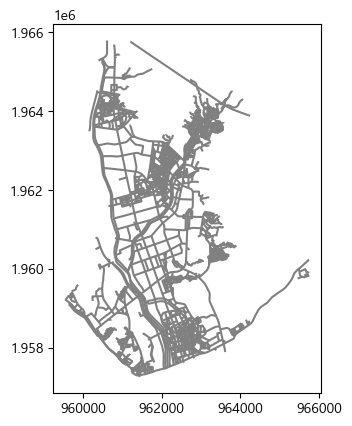

In [28]:
nowon_streets.plot(color='grey')

### clients(동), facility(약국)

#### clients(동)

In [29]:
dong = pd.read_csv("data/노원구행정동위경도.csv", encoding="cp949")

In [30]:
dong

,시도,시군구,읍면동/구,latitude,longitude
0,서울특별시,노원구,상계10동,37.661274,127.060225
1,서울특별시,노원구,상계9동,37.664553,127.063835
2,서울특별시,노원구,상계8동,37.666785,127.051587
3,서울특별시,노원구,상계6.7동,37.654882,127.066954
4,서울특별시,노원구,상계5동,37.662739,127.069498
5,서울특별시,노원구,상계3.4동,37.672913,127.083266
6,서울특별시,노원구,상계2동,37.657473,127.067838
7,서울특별시,노원구,상계1동,37.679901,127.054978
8,서울특별시,노원구,중계2.3동,37.642183,127.068713
9,서울특별시,노원구,중계4동,37.658727,127.078009


In [31]:
dong = geopandas.GeoDataFrame(dong)

In [32]:
dong = geopandas.GeoDataFrame(dong, geometry=geopandas.points_from_xy(dong.longitude, dong.latitude))

In [33]:
dong.crs = {'init':'epsg:4326'}

In [34]:
dong = dong.to_crs({'init':'epsg:5179'})

In [35]:
dong

,시도,시군구,읍면동/구,latitude,longitude,geometry
0,서울특별시,노원구,상계10동,37.661274,127.060225,POINT (961211.914 1962509.683)
1,서울특별시,노원구,상계9동,37.664553,127.063835,POINT (961531.983 1962871.99)
2,서울특별시,노원구,상계8동,37.666785,127.051587,POINT (960453 1963124.762)
3,서울특별시,노원구,상계6.7동,37.654882,127.066954,POINT (961802.148 1961797.752)
4,서울특별시,노원구,상계5동,37.662739,127.069498,POINT (962030.542 1962668.447)
5,서울특별시,노원구,상계3.4동,37.672913,127.083266,POINT (963249.92 1963791.742)
6,서울특별시,노원구,상계2동,37.657473,127.067838,POINT (961881.413 1962084.821)
7,서울특별시,노원구,상계1동,37.679901,127.054978,POINT (960758.946 1964578.427)
8,서울특별시,노원구,중계2.3동,37.642183,127.068713,POINT (961950.783 1960388.119)
9,서울특별시,노원구,중계4동,37.658727,127.078009,POINT (962779.205 1962219.951)


In [36]:
# dong = dong.sjoin(seoul_sig, how='right', predicate ='within')

In [37]:
nowon_clients = dong

In [38]:
nowon_clients

,시도,시군구,읍면동/구,latitude,longitude,geometry
0,서울특별시,노원구,상계10동,37.661274,127.060225,POINT (961211.914 1962509.683)
1,서울특별시,노원구,상계9동,37.664553,127.063835,POINT (961531.983 1962871.99)
2,서울특별시,노원구,상계8동,37.666785,127.051587,POINT (960453 1963124.762)
3,서울특별시,노원구,상계6.7동,37.654882,127.066954,POINT (961802.148 1961797.752)
4,서울특별시,노원구,상계5동,37.662739,127.069498,POINT (962030.542 1962668.447)
5,서울특별시,노원구,상계3.4동,37.672913,127.083266,POINT (963249.92 1963791.742)
6,서울특별시,노원구,상계2동,37.657473,127.067838,POINT (961881.413 1962084.821)
7,서울특별시,노원구,상계1동,37.679901,127.054978,POINT (960758.946 1964578.427)
8,서울특별시,노원구,중계2.3동,37.642183,127.068713,POINT (961950.783 1960388.119)
9,서울특별시,노원구,중계4동,37.658727,127.078009,POINT (962779.205 1962219.951)


#### facility(약국)

In [39]:
pharmacy = pd.read_csv('data/노원구심야약국후보지.csv')

In [40]:
pharmacy = geopandas.GeoDataFrame(pharmacy, geometry=geopandas.points_from_xy(pharmacy.longitude, pharmacy.latitude))

In [41]:
pharmacy.crs = {'init':'epsg:4326'} 

In [42]:
pharmacy = pharmacy.to_crs({'init':'epsg:5179'})

In [43]:
nowon_facility = pharmacy

In [44]:
nowon_facility

,name,location,longitude,latitude,open time,close time,run time,geometry
0,무궁화약국,서울특별시 노원구 한글비석로 77 1층,127.070437,37.637580,9:00,22:00,09:00 ~ 22:00,POINT (962100.577 1959876.759)
1,중앙메디칼약국,서울 노원구 공릉로46길 23 공릉동 한보아파트 상가,127.080363,37.628059,9:00,29:30:00,09:00 ~ 익일 05:30,POINT (962971.607 1958816.524)
2,행복한약국,서울 노원구 공릉로 187 건설빌딩,127.078878,37.626430,9:00,29:30:00,09:00 ~ 익일 05:30,POINT (962839.76 1958636.291)
3,화랑온누리약국,"서울특별시 노원구 공릉로 150 1층, 공릉동",127.079599,37.623357,9:00,22:00,09:00 ~ 22:00,POINT (962901.855 1958295.092)
4,샘물약국,서울특별시 노원구 노원로 43(공릉동),127.085764,37.625398,9:00,22:00,09:00 ~ 22:00,POINT (963446.885 1958519.113)
5,새고운약국,서울특별시 노원구 동일로 1003 1층 새고운약국,127.074623,37.619693,9:00,25:00:00,09:00 ~ 익일 01:00,POINT (962460.905 1957890.588)
6,건강과행복이열리는약국,서울특별시 노원구 한글비석로 242 삼부프라자 113호,127.076941,37.649298,9:00,22:00,09:00 ~ 22:00,POINT (962680.276 1961174.196)
7,새하늘약국,서울 노원구 동일로 1308 중계역1번출구 앞(다이소/ 파리비게트건물),127.065709,37.646674,9:00,22:00,09:00 ~ 22:00,POINT (961688.104 1960887.579)
8,다나약국,서울특별시 노원구 월계동 411-53 1층102호,127.061158,37.622899,8:30,29:30:00,08:30 ~ 익일 05:30,POINT (961274.289 1958251.761)
9,석사민주약국,서울특별시 노원구 한글비석로 253 205호,127.076330,37.650407,9:00,29:30:00,09:00 ~ 익일 05:30,POINT (962626.933 1961297.434)


<AxesSubplot: >

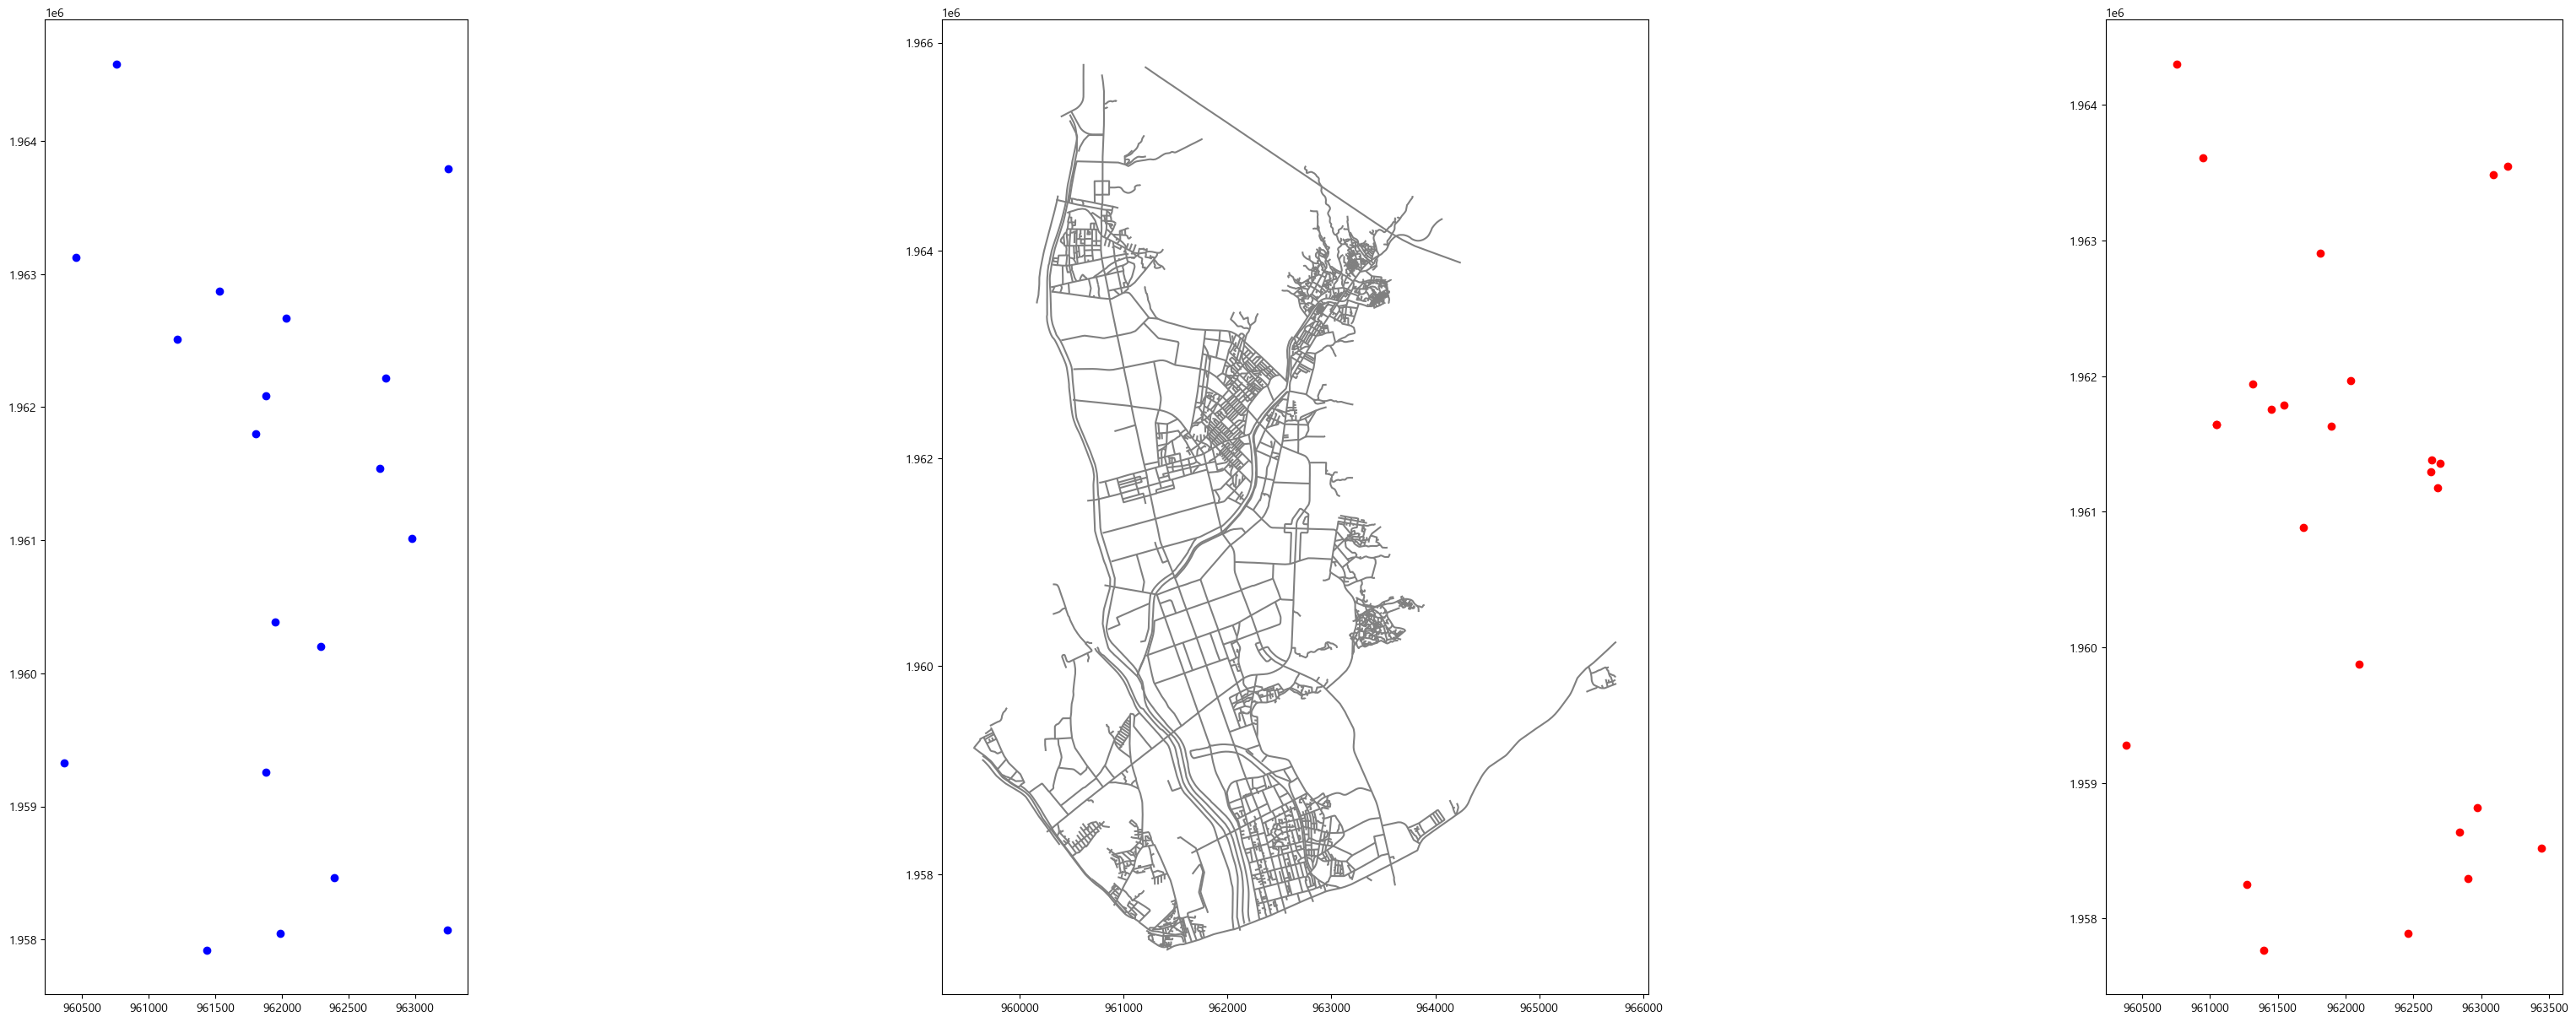

In [45]:
fig,ax = plt.subplots(1,3,figsize=(45,15))
nowon_clients.plot(color='blue',ax=ax[0])
nowon_streets.plot(color='grey',ax=ax[1])
nowon_facility.plot(color='red',ax=ax[2])

### 세팅

In [82]:
# 고객수, 필요 설치개수 = x,y
client_count, facility_count = nowon_clients.shape[0], nowon_facility.shape[0]
# plot 제목
title = "Nowon Neighborhood X"

In [47]:
buff = 20 # 가정
streets_buffer = get_buffer(nowon_streets, buff=buff)

In [48]:
streets = nowon_streets
#구분자 삽입
clients = nowon_clients
clients["dv"] = ["x[%s]" % c for c in range(client_count)]
#구분자 삽입
facilities = nowon_facility
facilities["dv"] = ["y[%s]" % c for c in range(facility_count)]

display(clients.head(2))
display(facilities.head())

,시도,시군구,읍면동/구,latitude,longitude,geometry,dv
0,서울특별시,노원구,상계10동,37.661274,127.060225,POINT (961211.914 1962509.683),x[0]
1,서울특별시,노원구,상계9동,37.664553,127.063835,POINT (961531.983 1962871.99),x[1]


,name,location,longitude,latitude,open time,close time,run time,geometry,dv
0,무궁화약국,서울특별시 노원구 한글비석로 77 1층,127.070437,37.637580,9:00,22:00,09:00 ~ 22:00,POINT (962100.577 1959876.759),y[0]
1,중앙메디칼약국,서울 노원구 공릉로46길 23 공릉동 한보아파트 상가,127.080363,37.628059,9:00,29:30:00,09:00 ~ 익일 05:30,POINT (962971.607 1958816.524),y[1]
2,행복한약국,서울 노원구 공릉로 187 건설빌딩,127.078878,37.626430,9:00,29:30:00,09:00 ~ 익일 05:30,POINT (962839.76 1958636.291),y[2]
3,화랑온누리약국,"서울특별시 노원구 공릉로 150 1층, 공릉동",127.079599,37.623357,9:00,22:00,09:00 ~ 22:00,POINT (962901.855 1958295.092),y[3]
4,샘물약국,서울특별시 노원구 노원로 43(공릉동),127.085764,37.625398,9:00,22:00,09:00 ~ 22:00,POINT (963446.885 1958519.113),y[4]


NameError: name 'add_legend' is not defined

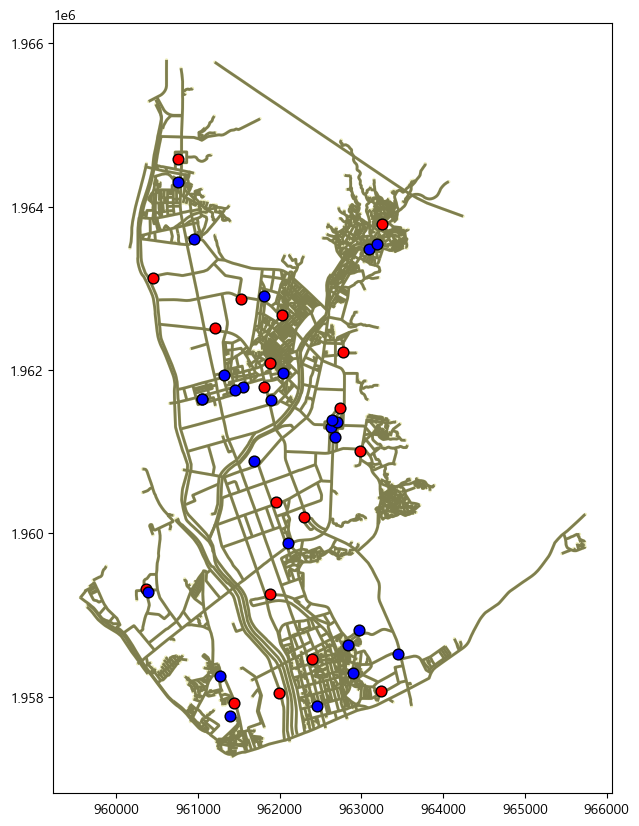

In [49]:
add_to_plot = {
    "streets": streets,
    "buffer": streets_buffer,
    "cli_tru": clients,
    "fac_tru": facilities,
}

plotter(plot_aux=add_to_plot, buffered=buff, pt1_size=60,figsize=(10,10))

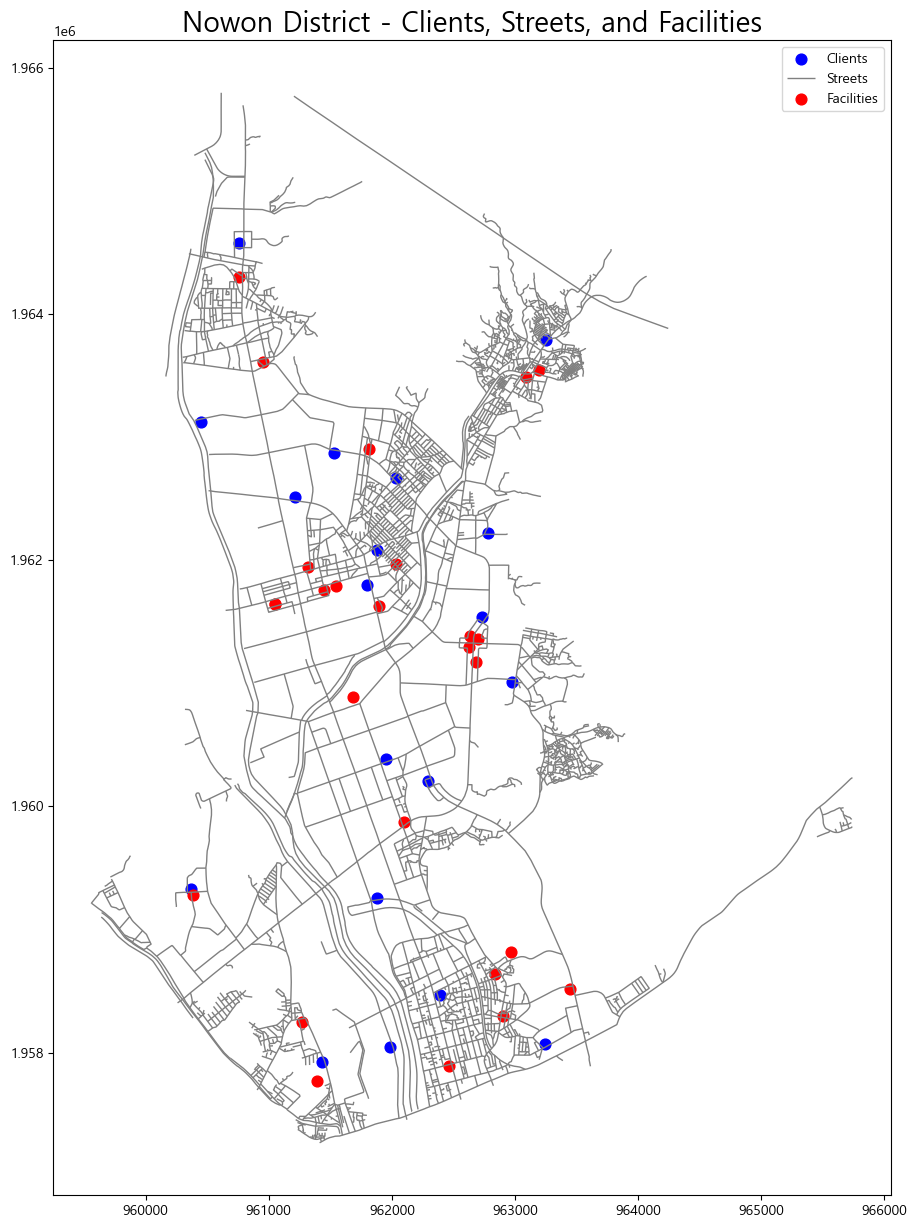

In [50]:
# 단일 플롯 생성
fig, ax = plt.subplots(figsize=(15, 15))  # 큰 사이즈로 플롯 생성

# 각 데이터셋을 동일한 ax에 플롯
nowon_clients.plot(ax=ax, color='blue', markersize=60, label='Clients')  # 고객 데이터 플롯
nowon_streets.plot(ax=ax, color='grey', linewidth=1, label='Streets')  # 도로 네트워크 플롯
nowon_facility.plot(ax=ax, color='red', markersize=60, label='Facilities')  # 시설 데이터 플롯

# 범례 추가
ax.legend()

# 플롯 제목 설정
ax.set_title('Nowon District - Clients, Streets, and Facilities', fontsize=20)

# 플롯 표시
plt.show()



### 모델링

In [51]:
# 네트워크 불러오기
ntw = spaghetti.Network(in_data=streets)
ntw.snapobservations(clients, "clients", attribute=True)
clients_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="clients", snapped=True
)
ntw.snapobservations(facilities, "facilities", attribute=True)
facilities_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="facilities", snapped=True
)

In [52]:
# Cost Matrix 계산 시간 소요
cost_matrix = ntw.allneighbordistances(
    sourcepattern=ntw.pointpatterns["clients"],
    destpattern=ntw.pointpatterns["facilities"],
)
cost_matrix[:3,:3]

array([[3143.24495935, 4801.64314508, 4743.24234966],
       [3465.98465802, 5124.38284375, 5065.98204833],
       [4918.94768666, 6577.34587239, 6518.94507697]])

In [55]:
cost_matrix

array([[3143.24495935, 4801.64314508, 4743.24234966, 5068.22923128,
        4868.63883329, 5618.26652675, 2641.77668464, 2151.02806301,
        5327.94049708, 2358.47754178, 2403.63642502, 2374.20481204,
        5511.89351989, 5945.54863559, 1212.08827341,  988.2176646 ,
        1089.22355304,  992.82650235, 1246.26737051, 1246.18248725,
         656.96862801, 1230.79346944, 2851.55730615, 2958.4026754 ,
        1950.5431174 , 3489.57748601],
       [3465.98465802, 5124.38284375, 5065.98204833, 5390.96892995,
        5191.37853196, 5941.00622542, 2503.87325941, 2473.76776168,
        5650.68019575, 2375.191447  , 2324.60774519, 2297.58176457,
        5834.63321856, 6268.28833426, 1534.82797208, 1449.85767933,
        1284.70730047, 1596.50963699, 1849.95050514, 1849.86562188,
        1260.65176264,  365.34423102, 2392.84377437, 2458.34071997,
        1166.36531118, 2705.39967978],
       [4918.94768666, 6577.34587239, 6518.94507697, 6843.93195859,
        6644.34156061, 7393.96925406, 

In [53]:
medical_score = pd.read_csv(r"data\medical_vulnerability_and_population_with_t_scores.csv")

In [54]:
medical_score.head()

,행정동,65세 이상 인구수,기초생활수급자수,전체인구수,Z-score 65세 이상 인구수,Z-score 기초생활수급자수,Z-score 전체 인구수,의료취약지수,행정동 별 인구에 따른 의료 취약도 점수
0,월계1동,4489.0,613,20410.0,-0.383999,-0.621757,-0.842452,-0.502878,54.236504
1,월계2동,6428.0,2244,25393.0,0.720278,1.205771,-0.104315,0.963025,48.995417
2,월계3동,6756.0,1568,28525.0,0.907077,0.448316,0.359631,0.677697,52.437206
3,공릉1동,7287.0,1811,35906.0,1.209486,0.720596,1.452986,0.965041,64.021910
4,공릉2동,6418.0,611,41448.0,0.714583,-0.623998,2.273927,0.045293,51.029922


In [55]:
clients

,시도,시군구,읍면동/구,latitude,longitude,geometry,dv
0,서울특별시,노원구,상계10동,37.661274,127.060225,POINT (961211.914 1962509.683),x[0]
1,서울특별시,노원구,상계9동,37.664553,127.063835,POINT (961531.983 1962871.99),x[1]
2,서울특별시,노원구,상계8동,37.666785,127.051587,POINT (960453 1963124.762),x[2]
3,서울특별시,노원구,상계6.7동,37.654882,127.066954,POINT (961802.148 1961797.752),x[3]
4,서울특별시,노원구,상계5동,37.662739,127.069498,POINT (962030.542 1962668.447),x[4]
5,서울특별시,노원구,상계3.4동,37.672913,127.083266,POINT (963249.92 1963791.742),x[5]
6,서울특별시,노원구,상계2동,37.657473,127.067838,POINT (961881.413 1962084.821),x[6]
7,서울특별시,노원구,상계1동,37.679901,127.054978,POINT (960758.946 1964578.427),x[7]
8,서울특별시,노원구,중계2.3동,37.642183,127.068713,POINT (961950.783 1960388.119),x[8]
9,서울특별시,노원구,중계4동,37.658727,127.078009,POINT (962779.205 1962219.951),x[9]


In [56]:
clients

,시도,시군구,읍면동/구,latitude,longitude,geometry,dv
0,서울특별시,노원구,상계10동,37.661274,127.060225,POINT (961211.914 1962509.683),x[0]
1,서울특별시,노원구,상계9동,37.664553,127.063835,POINT (961531.983 1962871.99),x[1]
2,서울특별시,노원구,상계8동,37.666785,127.051587,POINT (960453 1963124.762),x[2]
3,서울특별시,노원구,상계6.7동,37.654882,127.066954,POINT (961802.148 1961797.752),x[3]
4,서울특별시,노원구,상계5동,37.662739,127.069498,POINT (962030.542 1962668.447),x[4]
5,서울특별시,노원구,상계3.4동,37.672913,127.083266,POINT (963249.92 1963791.742),x[5]
6,서울특별시,노원구,상계2동,37.657473,127.067838,POINT (961881.413 1962084.821),x[6]
7,서울특별시,노원구,상계1동,37.679901,127.054978,POINT (960758.946 1964578.427),x[7]
8,서울특별시,노원구,중계2.3동,37.642183,127.068713,POINT (961950.783 1960388.119),x[8]
9,서울특별시,노원구,중계4동,37.658727,127.078009,POINT (962779.205 1962219.951),x[9]


In [128]:
# weight 컬럼 삭제
clients.drop(columns=['weight'], inplace=True)

In [57]:
# 병합하기 위해 컬럼 이름 맞추기 (동 이름 기준으로)
clients.rename(columns={'읍면동/구': '행정동'}, inplace=True)

# 병합: '행정동' 기준으로 두 데이터프레임 병합 (left join)
clients = pd.merge(clients, medical_score[['행정동', '행정동 별 인구에 따른 의료 취약도 점수']], on='행정동', how='left')

# 't_score'를 'weight'로 이름 변경
clients.rename(columns={'행정동 별 인구에 따른 의료 취약도 점수': 'weight'}, inplace=True)

# 결과 출력
print(clients)

       시도  시군구     행정동   latitude   longitude                        geometry  \
0   서울특별시  노원구   상계10동  37.661274  127.060225  POINT (961211.914 1962509.683)   
1   서울특별시  노원구    상계9동  37.664553  127.063835   POINT (961531.983 1962871.99)   
2   서울특별시  노원구    상계8동  37.666785  127.051587      POINT (960453 1963124.762)   
3   서울특별시  노원구  상계6.7동  37.654882  127.066954  POINT (961802.148 1961797.752)   
4   서울특별시  노원구    상계5동  37.662739  127.069498  POINT (962030.542 1962668.447)   
5   서울특별시  노원구  상계3.4동  37.672913  127.083266   POINT (963249.92 1963791.742)   
6   서울특별시  노원구    상계2동  37.657473  127.067838  POINT (961881.413 1962084.821)   
7   서울특별시  노원구    상계1동  37.679901  127.054978  POINT (960758.946 1964578.427)   
8   서울특별시  노원구  중계2.3동  37.642183  127.068713  POINT (961950.783 1960388.119)   
9   서울특별시  노원구    중계4동  37.658727  127.078009  POINT (962779.205 1962219.951)   
10  서울특별시  노원구    중계1동  37.652599  127.077528  POINT (962733.663 1961540.163)   
11  서울특별시  노원구    중계본동  37.6

In [97]:
mclp = FacilityLocationModel("mclp", ai=clients['weight'], cij = cost_matrix, p=5, s=1000)
clients, facilities = add_results(mclp, clients, facilities)

Solve Time: 0.0002666672 minutes
Obj. Value: 640.4187167024863 residents within 1000.000000 meters of 5 selected facilities
Percent of 1028 clients covered: 62.240897
--- 7 clients are not covered
--- 12 clients are covered by 1 facility
--- 1 clients are covered by 2 facilities


{'y[0]': 'firebrick', 'y[1]': 'silver', 'y[2]': 'mediumseagreen', 'y[3]': 'blueviolet', 'y[4]': 'aqua', 'y[5]': 'crimson', 'y[6]': 'cyan', 'y[7]': 'limegreen', 'y[8]': 'snow', 'y[9]': 'mintcream', 'y[10]': 'lemonchiffon', 'y[11]': 'lightcoral', 'y[12]': 'peachpuff', 'y[13]': 'mediumvioletred', 'y[14]': 'salmon', 'y[15]': 'rebeccapurple', 'y[16]': 'rebeccapurple', 'y[17]': 'ivory', 'y[18]': 'lavenderblush', 'y[19]': 'deeppink', 'y[20]': 'darkmagenta', 'y[21]': 'olive', 'y[22]': 'indigo', 'y[23]': 'cornsilk', 'y[24]': 'cornflowerblue', 'y[25]': 'red'}


NameError: name 'add_legend' is not defined

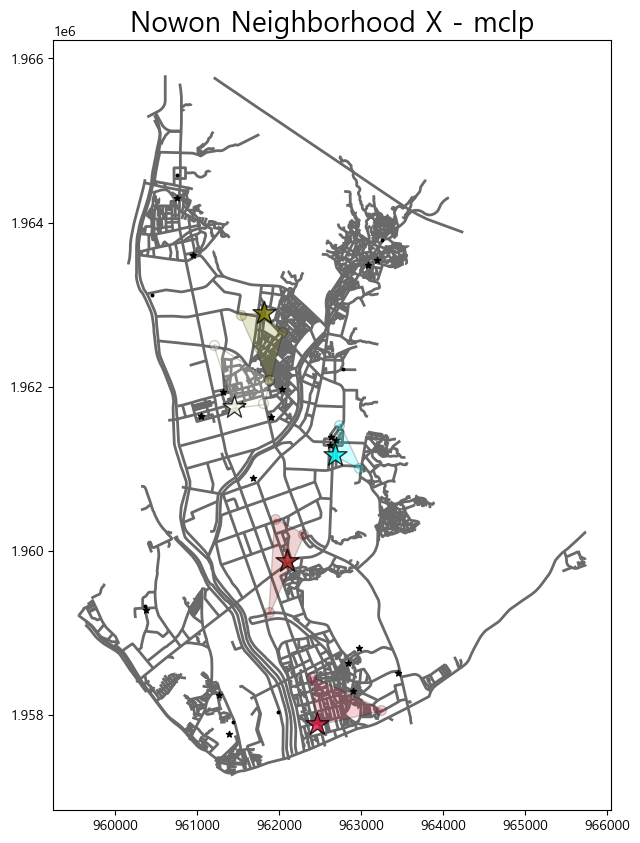

In [98]:
aux_to_plot = {"streets": streets, "cli_tru": clients, "fac_tru": facilities}
res_to_plot = {"cli_var": clients, "fac_var": facilities}
plotter(
    plot_aux=aux_to_plot,
    plot_res=res_to_plot,
    pt1_size=100,
    pt2_size=20,
    model=mclp,
    title=title,
)